In [1]:
import os
import tarfile
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import nltk
from nltk.data import find
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import sentiwordnet as swn
import matplotlib.pyplot as plt


# Extract IMDb dataset
def extract_imdb_dataset(tar_path, extract_to="./imdb_dataset"):
    if not os.path.exists(tar_path):
        print(f"Dataset file '{tar_path}' not found.")
        print("Please download the IMDb dataset manually and place it in the specified path.")
        return None

    if not os.path.exists(extract_to + "/aclImdb") or not os.listdir(extract_to + "/aclImdb"):
        print("Extracting IMDb dataset...")
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=extract_to)
        print("Extraction complete.")
    else:
        print("IMDb dataset already extracted.")
    return extract_to


# Load IMDb dataset
def load_imdb_data(dataset_dir):
    print("Loading data...")
    texts, labels = [], []
    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            dir_path = os.path.join(dataset_dir, split, sentiment)
            label = 1 if sentiment == "pos" else 0
            for file in os.listdir(dir_path):
                with open(os.path.join(dir_path, file), "r", encoding="utf-8") as f:
                    texts.append(f.read())
                    labels.append(label)
    print("Data has been loaded.")
    return texts, labels


# Tokenize texts and build vocabulary
def build_vocab(texts, tokenizer, special_tokens=["<PAD>", "<UNK>"]):
    print("Tokenizing texts...")
    vocab = {token: idx for idx, token in enumerate(special_tokens)}
    for text in texts:
        tokens = tokenizer.tokenize(text.lower())
        for token in tokens:
            if token not in vocab:
                vocab[token] = len(vocab)
    print("Texts have been tokenized and vocabulary has been built.")
    return vocab


# Define a function to build the lexicon
def build_lexicon_from_swn():
    print("Assigning lexicon sentiment scores...")

    # Function to ensure `sentiwordnet` and `wordnet` resources are downloaded
    def ensure_resource_downloaded(resource_name):
        try:
            nltk.data.find(resource_name)
            print(f"Resource '{resource_name}' is already downloaded.")
        except LookupError:
            print(f"Resource '{resource_name}' not found. Downloading now...")
            nltk.download(resource_name)

    ensure_resource_downloaded("sentiwordnet")
    ensure_resource_downloaded("wordnet")

    lexicon = {}
    for word in swn.all_senti_synsets():
        word_key = word.synset.name().split('.')[0]

        # Extract sentiment scores
        pos_score = word.pos_score()
        neg_score = word.neg_score()
        obj_score = 1 - pos_score - neg_score

        # Add part-of-speech encoding (4 dimensions: Noun, Verb, Adjective, Adverb)
        pos_tag = word.synset.pos()
        pos_one_hot = np.zeros(4)
        if pos_tag == 'n':
            pos_one_hot[0] = 1
        elif pos_tag == 'v':
            pos_one_hot[1] = 1
        elif pos_tag == 'a':
            pos_one_hot[2] = 1
        elif pos_tag == 'r':
            pos_one_hot[3] = 1

        # Add random features for additional dimensions (trainable embeddings later)
        random_features = np.random.uniform(-1, 1, 3)

        # Combine features into a single 10-dimensional vector
        lexicon_features = np.concatenate([[pos_score, neg_score, obj_score], pos_one_hot, random_features])

        # Avoid overwriting and average scores for duplicate entries
        if word_key in lexicon:
            lexicon[word_key] = (lexicon[word_key] + lexicon_features) / 2
        else:
            lexicon[word_key] = lexicon_features

    print("Lexicon sentiment scores has been assigned.")
    return lexicon


# Define preprocessing functions
def preprocess_text(text, vocab, max_len):
    tokenizer = TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text.lower())
    token_indices = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    token_indices = token_indices[:max_len] + [0] * (max_len - len(token_indices))
    return token_indices

def get_lexicon_features(text, lexicon, vocab, max_len, feature_dim=10):
    tokenizer = TreebankWordTokenizer()
    tokens = tokenizer.tokenize(text.lower())

    features = []
    for token in tokens:
        if token in lexicon:
            features.append(lexicon[token])
        else:
            features.append([0.0] * feature_dim)

    if len(features) < max_len:
        # Pad with zero vectors if the sequence is shorter than max_len
        padding = [[0.0] * feature_dim] * (max_len - len(features))
        features.extend(padding)
    else:
        # Truncate to max_len if the sequence is longer
        features = features[:max_len]

    return features


# Define dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab, lexicon, max_len=512, device="cpu"):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.lexicon = lexicon
        self.max_len = max_len
        self.device = device

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        token_indices = preprocess_text(text, self.vocab, self.max_len)
        lexicon_features = get_lexicon_features(text, self.lexicon, self.vocab, self.max_len)
        return {
            "tokens": torch.tensor(token_indices, dtype=torch.long).to(self.device),
            "lexicon_features": torch.from_numpy(np.array(lexicon_features, dtype=np.float32)).to(self.device),
            "label": torch.tensor(label, dtype=torch.long).to(self.device)
        }

# Prepare data

In [2]:
# Path to IMDb dataset
tar_path = "./imdb_dataset/aclImdb_v1.tar.gz"
extracted_path = "./imdb_dataset"

# Extract and load the dataset
extract_imdb_dataset(tar_path, extracted_path)
texts, labels = load_imdb_data(extracted_path + "/aclImdb")


# Tokenize and build vocabulary
tokenizer = TreebankWordTokenizer()
vocab = build_vocab(texts, tokenizer)

# Build the lexicon
lexicon = build_lexicon_from_swn()

# Create the PyTorch Dataset
dataset = SentimentDataset(texts, labels, vocab, lexicon)

IMDb dataset already extracted.
Loading data...
Data has been loaded.
Tokenizing texts...
Texts have been tokenized and vocabulary has been built.
Assigning lexicon sentiment scores...
Resource 'sentiwordnet' not found. Downloading now...
Resource 'wordnet' not found. Downloading now...


[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Lexicon sentiment scores has been assigned.


# Baseline CNN Model

In [3]:
class BaselineCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, kernel_sizes=[3, 4, 5], num_filters=50, dropout=0.5):
        super(BaselineCNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embedding_dim))
            for k in kernel_sizes
        ])

        # Fully connected layer
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, tokens, lexicon_features=None):
        # Word embeddings
        embed = self.embedding(tokens)  # [batch_size, seq_len, embedding_dim]

        # Add channel dimension for CNN
        embed = embed.unsqueeze(1)  # [batch_size, 1, seq_len, embedding_dim]

        # Apply convolution and pooling
        conv_outputs = [
            torch.relu(conv(embed)).squeeze(3) for conv in self.convs
        ]  # List of [batch_size, num_filters, seq_len - kernel_size + 1]
        pooled_outputs = [torch.max(conv, dim=2)[0] for conv in conv_outputs]  # [batch_size, num_filters]

        # Concatenate and classify
        concatenated = torch.cat(pooled_outputs, dim=1)  # [batch_size, len(kernel_sizes) * num_filters]
        dropped = self.dropout(concatenated)
        logits = self.fc(dropped)  # [batch_size, num_classes]
        return self.softmax(logits)

# Create model
vocab_size = len(vocab)
embedding_dim = 50
num_classes = 2

baseline_model = BaselineCNN(vocab_size, embedding_dim, num_classes)
print(baseline_model)

BaselineCNN(
  (embedding): Embedding(187679, 50)
  (convs): ModuleList(
    (0): Conv2d(1, 50, kernel_size=(3, 50), stride=(1, 1))
    (1): Conv2d(1, 50, kernel_size=(4, 50), stride=(1, 1))
    (2): Conv2d(1, 50, kernel_size=(5, 50), stride=(1, 1))
  )
  (fc): Linear(in_features=150, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)


In [4]:
# Split the Dataset
train_split = 0.8
train_size = int(train_split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Display split information
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 40000
Testing samples: 10000


In [5]:
# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Move the model to the device
baseline_model = baseline_model.to(device)

# Define the training and evaluation functions
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=10, device="cpu"):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        # Training loop
        for batch in train_loader:
            tokens = batch["tokens"].to(device)
            lexicon_features = batch["lexicon_features"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(tokens, lexicon_features)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

        # Calculate training metrics
        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate on the test set
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
        print(f"  Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies

def evaluate_model(model, test_loader, criterion, device="cpu"):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for batch in test_loader:
            tokens = batch["tokens"].to(device)
            lexicon_features = batch["lexicon_features"].to(device)
            labels = batch["label"].to(device)

            outputs = model(tokens, lexicon_features)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

    accuracy = correct / len(test_loader.dataset)
    return total_loss / len(test_loader), accuracy

# Training setup
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)  # Adam optimizer
epochs = 10

# Train the model and record metrics
train_losses_md1, train_accuracies_md1, test_losses_md1, test_accuracies_md1 = train_model(
    baseline_model, train_loader, test_loader, optimizer, criterion, epochs, device
)

Using device: cuda
Epoch 1/10:
  Train Loss: 0.6335 | Train Accuracy: 0.6383
  Test Loss: 0.5274 | Test Accuracy: 0.7748
Epoch 2/10:
  Train Loss: 0.5464 | Train Accuracy: 0.7497
  Test Loss: 0.5034 | Test Accuracy: 0.8011
Epoch 3/10:
  Train Loss: 0.5068 | Train Accuracy: 0.7941
  Test Loss: 0.4704 | Test Accuracy: 0.8320
Epoch 4/10:
  Train Loss: 0.4772 | Train Accuracy: 0.8272
  Test Loss: 0.4536 | Test Accuracy: 0.8525
Epoch 5/10:
  Train Loss: 0.4538 | Train Accuracy: 0.8530
  Test Loss: 0.4456 | Test Accuracy: 0.8578
Epoch 6/10:
  Train Loss: 0.4330 | Train Accuracy: 0.8758
  Test Loss: 0.4423 | Test Accuracy: 0.8630
Epoch 7/10:
  Train Loss: 0.4155 | Train Accuracy: 0.8935
  Test Loss: 0.4373 | Test Accuracy: 0.8685
Epoch 8/10:
  Train Loss: 0.4006 | Train Accuracy: 0.9097
  Test Loss: 0.4357 | Test Accuracy: 0.8716
Epoch 9/10:
  Train Loss: 0.3893 | Train Accuracy: 0.9221
  Test Loss: 0.4366 | Test Accuracy: 0.8709
Epoch 10/10:
  Train Loss: 0.3798 | Train Accuracy: 0.9318
  Te

Plot saved to plots/training_and_test_accuracy_of_baseline_model.png


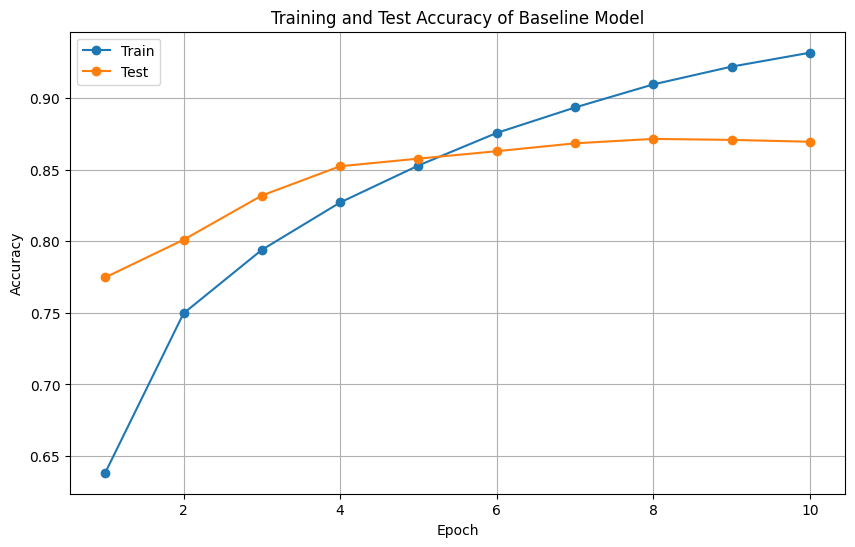

In [6]:
def plot_metrics(epochs, train_values, test_values, ylabel, title, save_folder="plots"):
    os.makedirs(save_folder, exist_ok=True)
    # Plot the metrics
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_values, label="Train", marker="o")
    plt.plot(epochs, test_values, label="Test", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    # Save the plot
    filename = f"{save_folder}/{title.replace(' ', '_').lower()}.png"
    plt.savefig(filename, bbox_inches="tight")
    print(f"Plot saved to {filename}")
    # Show the plot
    plt.show()

epochs_range = range(1, epochs + 1)

# Plot accuracy
plot_metrics(epochs_range, train_accuracies_md1, test_accuracies_md1, ylabel="Accuracy",
             title="Training and Test Accuracy of Baseline Model")

# Lexicon Integrated CNN Model

In [7]:
class LexiconIntegratedCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, lexicon_dim=10, kernel_sizes=[3, 4, 5], num_filters=50, dropout=0.5):
        super(LexiconIntegratedCNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embedding_dim + lexicon_dim))
            for k in kernel_sizes
        ])

        # Fully connected layer
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, tokens, lexicon_features):
        # Word embeddings
        embed = self.embedding(tokens)  # [batch_size, seq_len, embedding_dim]

        # Combine embeddings with lexicon features
        # lexicon_features is already 10-dimensional
        combined = torch.cat((embed, lexicon_features), dim=-1)  # [batch_size, seq_len, embedding_dim + lexicon_dim]

        # Add channel dimension for CNN
        combined = combined.unsqueeze(1)  # [batch_size, 1, seq_len, embedding_dim + lexicon_dim]

        # Apply convolution and pooling
        conv_outputs = [
            torch.relu(conv(combined)).squeeze(3) for conv in self.convs
        ]  # List of [batch_size, num_filters, seq_len - kernel_size + 1]
        pooled_outputs = [torch.max(conv, dim=2)[0] for conv in conv_outputs]  # [batch_size, num_filters]

        # Concatenate and classify
        concatenated = torch.cat(pooled_outputs, dim=1)  # [batch_size, len(kernel_sizes) * num_filters]
        dropped = self.dropout(concatenated)
        logits = self.fc(dropped)  # [batch_size, num_classes]
        return self.softmax(logits)


lexicon_dim = 10

lexicon_model = LexiconIntegratedCNN(vocab_size, embedding_dim, num_classes, lexicon_dim=lexicon_dim)
print(lexicon_model)

LexiconIntegratedCNN(
  (embedding): Embedding(187679, 50)
  (convs): ModuleList(
    (0): Conv2d(1, 50, kernel_size=(3, 60), stride=(1, 1))
    (1): Conv2d(1, 50, kernel_size=(4, 60), stride=(1, 1))
    (2): Conv2d(1, 50, kernel_size=(5, 60), stride=(1, 1))
  )
  (fc): Linear(in_features=150, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)


In [8]:
# Training setup

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
lexicon_model = lexicon_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lexicon_model.parameters(), lr=0.001)
epochs = 10

# Train the model and record metrics
train_losses_md2, train_accuracies_md2, test_losses_md2, test_accuracies_md2 = train_model(
    lexicon_model, train_loader, test_loader, optimizer, criterion, epochs, device
)

Using device: cuda
Epoch 1/10:
  Train Loss: 0.6198 | Train Accuracy: 0.6547
  Test Loss: 0.5246 | Test Accuracy: 0.7832
Epoch 2/10:
  Train Loss: 0.5296 | Train Accuracy: 0.7702
  Test Loss: 0.4765 | Test Accuracy: 0.8267
Epoch 3/10:
  Train Loss: 0.4858 | Train Accuracy: 0.8196
  Test Loss: 0.4529 | Test Accuracy: 0.8537
Epoch 4/10:
  Train Loss: 0.4527 | Train Accuracy: 0.8539
  Test Loss: 0.4416 | Test Accuracy: 0.8647
Epoch 5/10:
  Train Loss: 0.4260 | Train Accuracy: 0.8826
  Test Loss: 0.4360 | Test Accuracy: 0.8699
Epoch 6/10:
  Train Loss: 0.4069 | Train Accuracy: 0.9029
  Test Loss: 0.4327 | Test Accuracy: 0.8739
Epoch 7/10:
  Train Loss: 0.3896 | Train Accuracy: 0.9216
  Test Loss: 0.4400 | Test Accuracy: 0.8649
Epoch 8/10:
  Train Loss: 0.3791 | Train Accuracy: 0.9322
  Test Loss: 0.4324 | Test Accuracy: 0.8751
Epoch 9/10:
  Train Loss: 0.3683 | Train Accuracy: 0.9445
  Test Loss: 0.4330 | Test Accuracy: 0.8745
Epoch 10/10:
  Train Loss: 0.3618 | Train Accuracy: 0.9511
  Te

Plot saved to plots/training_and_test_accuracy_of_lexicon_model.png


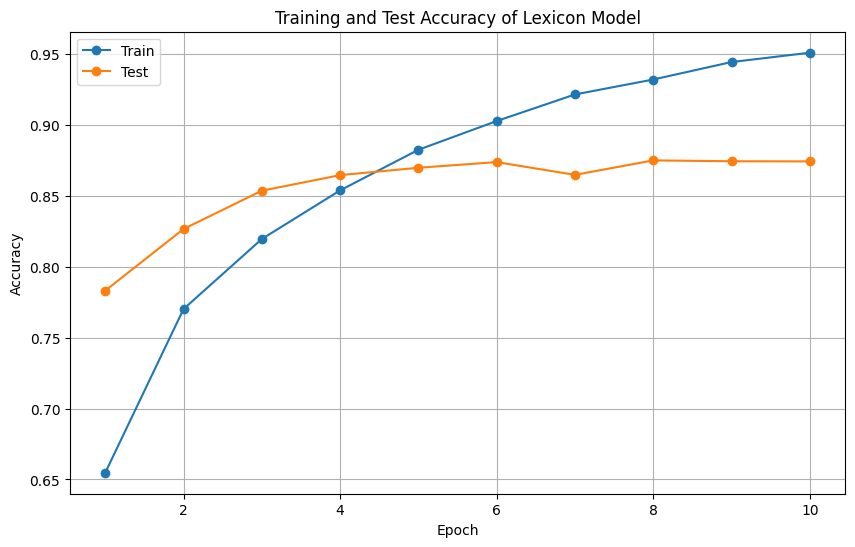

In [9]:
# Plot accuracy
plot_metrics(epochs_range, train_accuracies_md2, test_accuracies_md2, ylabel="Accuracy",
             title="Training and Test Accuracy of Lexicon Model")

# Lexicon Integrated CNN Model with Attention

In [10]:
import torch.nn.functional as F

class LexiconIntegratedAttentionCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, lexicon_dim=10, kernel_sizes=[3, 4, 5], num_filters=50, dropout=0.5):
        super(LexiconIntegratedAttentionCNN, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Attention layer
        self.attention_fc = nn.Linear(embedding_dim + lexicon_dim, 1)  # Compute attention scores

        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embedding_dim + lexicon_dim))
            for k in kernel_sizes
        ])

        # Fully connected layer
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tokens, lexicon_features):
        # Word embeddings
        embed = self.embedding(tokens)  # [batch_size, seq_len, embedding_dim]

        # Combine embeddings with lexicon features
        # lexicon_features shape: [batch_size, seq_len, lexicon_dim]
        combined = torch.cat((embed, lexicon_features), dim=-1)  # [batch_size, seq_len, embedding_dim + lexicon_dim]

        # Compute attention scores
        attention_scores = self.attention_fc(combined)  # [batch_size, seq_len, 1]
        attention_weights = F.softmax(attention_scores, dim=1)  # Normalize across the sequence

        # Apply attention
        combined = combined * attention_weights  # Element-wise weighting [batch_size, seq_len, embedding_dim + lexicon_dim]

        # Add channel dimension for CNN
        combined = combined.unsqueeze(1)  # [batch_size, 1, seq_len, embedding_dim + lexicon_dim]

        # Apply convolution and pooling
        conv_outputs = [
            torch.relu(conv(combined)).squeeze(3) for conv in self.convs
        ]  # List of [batch_size, num_filters, seq_len - kernel_size + 1]
        pooled_outputs = [torch.max(conv, dim=2)[0] for conv in conv_outputs]  # [batch_size, num_filters]

        # Concatenate and classify
        concatenated = torch.cat(pooled_outputs, dim=1)  # [batch_size, len(kernel_sizes) * num_filters]
        dropped = self.dropout(concatenated)
        logits = self.fc(dropped)  # [batch_size, num_classes]
        return logits


attention_model = LexiconIntegratedAttentionCNN(vocab_size, embedding_dim, num_classes, lexicon_dim=lexicon_dim)
print(attention_model)

LexiconIntegratedAttentionCNN(
  (embedding): Embedding(187679, 50)
  (attention_fc): Linear(in_features=60, out_features=1, bias=True)
  (convs): ModuleList(
    (0): Conv2d(1, 50, kernel_size=(3, 60), stride=(1, 1))
    (1): Conv2d(1, 50, kernel_size=(4, 60), stride=(1, 1))
    (2): Conv2d(1, 50, kernel_size=(5, 60), stride=(1, 1))
  )
  (fc): Linear(in_features=150, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [11]:
# Training setup

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
attention_model = attention_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(attention_model.parameters(), lr=0.001)
epochs = 10

# Train the model and record metrics
train_losses_md3, train_accuracies_md3, test_losses_md3, test_accuracies_md3 = train_model(
    attention_model, train_loader, test_loader, optimizer, criterion, epochs, device
)

Using device: cuda
Epoch 1/10:
  Train Loss: 0.6525 | Train Accuracy: 0.6109
  Test Loss: 0.5853 | Test Accuracy: 0.6957
Epoch 2/10:
  Train Loss: 0.5703 | Train Accuracy: 0.7062
  Test Loss: 0.5438 | Test Accuracy: 0.7299
Epoch 3/10:
  Train Loss: 0.5228 | Train Accuracy: 0.7431
  Test Loss: 0.5013 | Test Accuracy: 0.7612
Epoch 4/10:
  Train Loss: 0.4617 | Train Accuracy: 0.7815
  Test Loss: 0.4480 | Test Accuracy: 0.7937
Epoch 5/10:
  Train Loss: 0.4096 | Train Accuracy: 0.8133
  Test Loss: 0.4262 | Test Accuracy: 0.8071
Epoch 6/10:
  Train Loss: 0.3680 | Train Accuracy: 0.8348
  Test Loss: 0.4056 | Test Accuracy: 0.8223
Epoch 7/10:
  Train Loss: 0.3273 | Train Accuracy: 0.8586
  Test Loss: 0.3902 | Test Accuracy: 0.8288
Epoch 8/10:
  Train Loss: 0.2856 | Train Accuracy: 0.8807
  Test Loss: 0.3872 | Test Accuracy: 0.8396
Epoch 9/10:
  Train Loss: 0.2483 | Train Accuracy: 0.9005
  Test Loss: 0.3891 | Test Accuracy: 0.8439
Epoch 10/10:
  Train Loss: 0.2144 | Train Accuracy: 0.9152
  Te

Plot saved to plots/training_and_test_accuracy_of_lexicon_model_with_attention.png


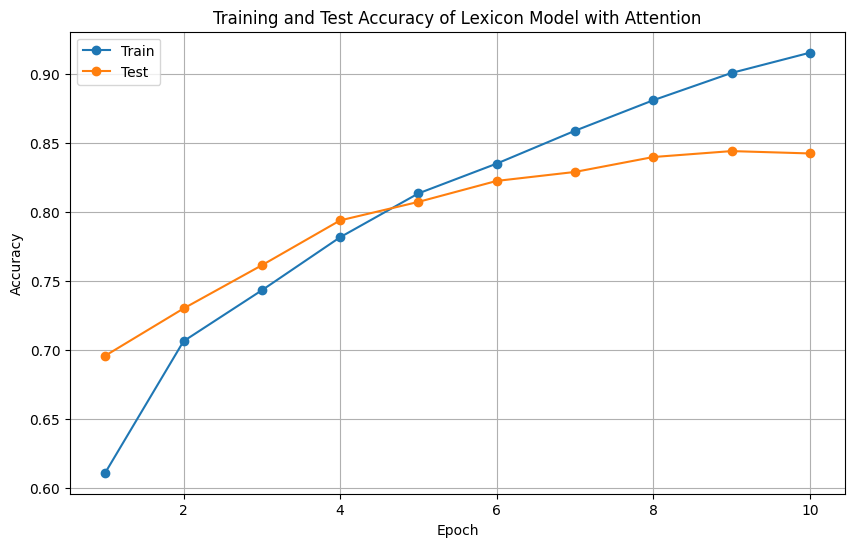

In [12]:
# Plot accuracy
plot_metrics(epochs_range, train_accuracies_md3, test_accuracies_md3, ylabel="Accuracy",
             title="Training and Test Accuracy of Lexicon Model with Attention")